# Overview of Diversity Analysis
This notebook explores microbial diversity metrics across different taxonomic levels and sample groups. The workflow includes:
- Loading and preprocessing microbiome data
- Calculating richness and alpha diversity metrics
- Visualizing diversity distributions and group comparisons
- Interpreting results in the context of biological and clinical variables
Each section below is accompanied by code and explanations to guide the reader through the analysis steps.

In [ ]:
# Set working directory
import os
os.chdir('/container/mount/point/')

import sys
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import IPython.display as display

from matplotlib_venn import venn2
from tqdm import tqdm
from scipy.stats import mannwhitneyu
from skbio.diversity import alpha_diversity
from skbio.diversity.alpha import faith_pd
from skbio import TreeNode
from PIL import Image

In [3]:
from utils.helper import transform_features

## Data Loading and Preprocessing
In this section, we load the microbiome count tables and associated metadata. Preprocessing steps may include filtering low-abundance features, normalizing counts, and preparing the data for diversity calculations. Proper data preparation is essential for accurate and meaningful diversity analysis.

In [5]:
def plot_alpha_diversity(alpha_diversity_test, alpha_diversity_ctrl, diversity_metric, status, level, p_value):
    """
    Create a box plot for alpha diversity values comparing allergic and non-allergic groups.
    """
    fig = go.Figure()
    fig.add_trace(go.Box(y=alpha_diversity_test, name='Allergic', boxpoints='outliers', jitter=0.1, marker_color="red"))
    fig.add_trace(go.Box(y=alpha_diversity_ctrl, name='Not Allergic', boxpoints='outliers', jitter=0.1, marker_color="green"))
    fig.update_layout(
        yaxis_title=f'{diversity_metric.capitalize()}',
        title=f'{status} data, {level}: p-value = {p_value:.4f}',
    )
    fig.add_annotation(
        text=f'N={len(alpha_diversity_test)}',
        x=0, y=max(alpha_diversity_test), xref='x', yref='y',
        showarrow=False, xanchor='center', yshift=10, font=dict(color='red')
    )
    fig.add_annotation(
        text=f'N={len(alpha_diversity_ctrl)}',
        x=1, y=max(alpha_diversity_ctrl), xref='x', yref='y',
        showarrow=False, xanchor='center', yshift=10, font=dict(color='green')
    )
    return fig

In [6]:
def add_label(label):
    """
    Helper for Sankey diagram: add label to global label list and index.
    """
    if label not in label_index:
        label_index[label] = len(labels)
        for i in range(len(labels)):
            if labels[i] not in ['phylum', 'class', 'order', 'family', 'genus', 'species']:
                last_part = labels[i].rsplit('__', 1)[-1]
                if 'unknown' in last_part:
                    index_value = last_part.split('_')[-1]
                    labels[i] = index_value
                else:
                    labels[i] = last_part.strip(';')
        labels.append(label)

In [7]:
def calculate_color_proportions(df):
    """
    Calculate the proportion of each color (group) in a DataFrame.
    """
    return df['color'].value_counts(normalize=True)

In [8]:
def extract_rank(df, rank_position):
    """
    Extract a taxonomic rank from the index.
    """
    return df.index.str.split(';').str[rank_position] + ';'

In [9]:
def join_dataframes(counts_dict, color_dict, key):
    """
    Join count and color DataFrames on a given taxonomic level.
    """
    df_counts = counts_dict[key]
    df_colors = color_dict[key]
    return df_counts.join(df_colors, on=key, how='inner')

In [10]:
def create_stacked_bar_plot(df, height=700, width=1000, lvl='Taxa'):
    """
    Create a stacked bar plot for healthy, mixed, and allergic taxa proportions.
    """
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df.index, y=df['healthy'], name='Healthy', marker_color='green'))
    fig.add_trace(go.Bar(x=df.index, y=df['mixed'], name='Mixed', marker_color='blue'))
    fig.add_trace(go.Bar(x=df.index, y=df['allergic'], name='Allergic', marker_color='red'))
    fig.update_layout(
        barmode='stack',
        title=f'({lvl}) Proportion of ASVs Belonging to IgE, Non-IgE, or Mixed Groups',
        xaxis_title='Taxa',
        yaxis_title='Frequency',
        legend_title='Group',
        height=height,
        width=width
    )
    return fig

In [22]:
def determine_status(row):
    """
    Assign color status based on sample group.
    """
    if row.name in only_healthy.index:
        return 'green'
    elif row.name in only_allergic.index:
        return 'red'
    else:
        return 'lightgrey'

## Alpha Diversity Analysis
Alpha diversity measures the richness and evenness of microbial communities within individual samples. Here, we calculate and visualize alpha diversity metrics (such as Shannon or Simpson indices) to compare diversity across groups and explore associations with clinical or environmental variables.

In [11]:
# Taxonomy and count data
taxa = pd.read_csv('data/taxonomy_clean.csv', sep=',', index_col=0)
taxa["ASV"] = taxa.index
asv = pd.read_csv("data/feature_table.tsv", index_col=0, sep='\t')
ASV_table = asv.copy()
taxa_freq = ASV_table.sum(axis=1)
non_zero_taxa = taxa_freq[taxa_freq > 0]
ASV_table_non_zero = ASV_table[ASV_table.index.isin(non_zero_taxa.index)]
means = ASV_table_non_zero.mean()
zero_mean_cols = means[means == 0].index
if any(zero_mean_cols):
    print(f"Zero mean features found and removed: {list(zero_mean_cols)}")
    count_table = ASV_table_non_zero.drop(zero_mean_cols, axis=1)
else:
    count_table = ASV_table_non_zero

Zero mean features found and removed: ['25803', '26152', '27493', '33231', '44871', '48127', '70492']


In [12]:
# Aggregate counts by taxonomic level
taxonomic_levels = ['phylum', 'class', 'order', 'family', 'genus', 'species', 'ASV']
count_dict = dict()
threshold = 0.01
for level in taxonomic_levels:
    print(f"\n--- Level: {level} ---")
    counts_plus_label = count_table.join(taxa[level])
    counts = counts_plus_label.groupby(level).sum()
    counts_freq = counts.astype(bool).sum(axis=1) / counts.shape[1]
    filter_threshold = counts_freq[counts_freq > threshold]
    counts_filtered = counts[counts.index.isin(filter_threshold.index)]
    print(counts_filtered.shape)
    count_dict[level] = {"all": counts_filtered}


--- Level: phylum ---
(13, 2027)

--- Level: class ---
(19, 2027)

--- Level: order ---
(46, 2027)

--- Level: family ---
(87, 2027)

--- Level: genus ---
(409, 2027)

--- Level: species ---
(1368, 2027)

--- Level: ASV ---
(1459, 2027)


In [13]:
# IgE and allergy status data
all_samples = pd.read_csv("data/ige_kora_subset_all.csv", sep=",", index_col='u3_16s_id', low_memory=False)
ige_samples = pd.read_csv("data/ige_clustered_275.csv", sep=",", index_col=0, low_memory=False)

single_multiple = all_samples.index[all_samples.astype(bool).sum(axis=1) >= 1].tolist()
single = all_samples.index[all_samples.astype(bool).sum(axis=1) == 1].tolist()
multiple = all_samples.index[all_samples.astype(bool).sum(axis=1) > 1].tolist()
no_allergy = all_samples.index[all_samples.astype(bool).sum(axis=1) == 0].tolist()
row_sums = ige_samples.sum(axis=1)
ige_score_vector = row_sums.sort_values(ascending=False)
score_order = ige_score_vector.index
score_order = [str(i) for i in score_order]
high_score = ige_score_vector[ige_score_vector > 15].index.tolist()
medium_score = ige_score_vector[(ige_score_vector <= 15) & (ige_score_vector > 5)].index.tolist()
low_score = ige_score_vector[ige_score_vector <= 5].index.tolist()
allergy_status = {
    "all_ige": single_multiple,
    "single": single,
    "multiple": multiple,
    "high_score": high_score,
    "medium_score": medium_score,
    "low_score": low_score,
    "no_allergy": no_allergy
}

In [14]:
# Cluster data
cluster_df = pd.read_csv("data/cluster_df_latent.csv", sep=",", index_col=0, low_memory=False)
cluster_df['sample_id'] = cluster_df.index
for cluster in cluster_df['cluster'].unique():
    allergy_status[cluster] = cluster_df.loc[cluster_df['cluster'] == cluster, 'sample_id'].tolist()
for key in allergy_status:
    print(f"{key.replace('_', ' ').title()} samples:", len(allergy_status[key]))

All Ige samples: 275
Single samples: 47
Multiple samples: 228
High Score samples: 57
Medium Score samples: 110
Low Score samples: 108
No Allergy samples: 233
A samples: 12
B samples: 24
C samples: 26
D samples: 45
E samples: 22
F samples: 10
I samples: 74
H samples: 40
G samples: 22


### Alpha Diversity Analysis (Shannon)

In [15]:
diversity_metric = 'shannon'
pvalue_dict = {"shannon": dict(), "faith_pd": dict()}
alpha_dict = dict()

In [16]:
for status in allergy_status.keys():
    print(f"\n ------------ {status} ------------")
    ige_ids = set(map(str, allergy_status[status]))
    non_ids = set(map(str, allergy_status['no_allergy']))
    count_ids = set(count_dict["ASV"]["all"].columns.astype(str))
    overlap_ids = count_ids.intersection(ige_ids | non_ids)
    allergic_ids = set(ige_ids)
    ctrl_ids = set(non_ids)
    allergic_ids_list = list(allergic_ids.intersection(overlap_ids))
    ctrl_ids_list = list(ctrl_ids.intersection(overlap_ids))
    if status not in pvalue_dict["shannon"]:
        pvalue_dict["shannon"][status] = dict()
    if status not in alpha_dict:
        alpha_dict[status] = dict()
    for level in taxonomic_levels:
        print(f"\n--- Level: {level} ---")
        counts = count_dict[level]["all"]
        if allergic_ids_list:
            test_counts = counts[allergic_ids_list].loc[~(counts[allergic_ids_list] == 0).all(axis=1)]
        if ctrl_ids_list:
            ctrl_counts = counts[ctrl_ids_list].loc[~(counts[ctrl_ids_list] == 0).all(axis=1)]
        print("Allergic: p={0}, N={1}".format(test_counts.shape[0], test_counts.shape[1]))
        print("Non-allergic: p={0}, N={1}".format(ctrl_counts.shape[0], ctrl_counts.shape[1]))
        alpha_diversity_test = alpha_diversity(diversity_metric, test_counts.T.values, ids=test_counts.T.index)
        alpha_diversity_ctrl = alpha_diversity(diversity_metric, ctrl_counts.T.values, ids=ctrl_counts.T.index)
        alpha_dict[status][level] = {"alpha_test": alpha_diversity_test, "alpha_ctrl": alpha_diversity_ctrl}
        stat, p_value = mannwhitneyu(alpha_diversity_test, alpha_diversity_ctrl, alternative='two-sided')
        pvalue_dict["shannon"][status][level] = {"stat": stat, "p-value": p_value}
        print(f"p-value={p_value:.4f}")


 ------------ all_ige ------------

--- Level: phylum ---
Allergic: p=13, N=275
Non-allergic: p=13, N=233
p-value=0.9145

--- Level: class ---
Allergic: p=19, N=275
Non-allergic: p=19, N=233
p-value=0.8210

--- Level: order ---
Allergic: p=45, N=275
Non-allergic: p=46, N=233
p-value=0.1756

--- Level: family ---
Allergic: p=85, N=275
Non-allergic: p=87, N=233
p-value=0.8097

--- Level: genus ---
Allergic: p=404, N=275
Non-allergic: p=406, N=233
p-value=0.9304

--- Level: species ---
Allergic: p=1352, N=275
Non-allergic: p=1348, N=233
p-value=0.4670

--- Level: ASV ---
Allergic: p=1441, N=275
Non-allergic: p=1437, N=233
p-value=0.5365

 ------------ single ------------

--- Level: phylum ---
Allergic: p=11, N=47
Non-allergic: p=13, N=233
p-value=0.9638

--- Level: class ---
Allergic: p=17, N=47
Non-allergic: p=19, N=233
p-value=0.8388

--- Level: order ---
Allergic: p=40, N=47
Non-allergic: p=46, N=233
p-value=0.0913

--- Level: family ---
Allergic: p=75, N=47
Non-allergic: p=87, N=233

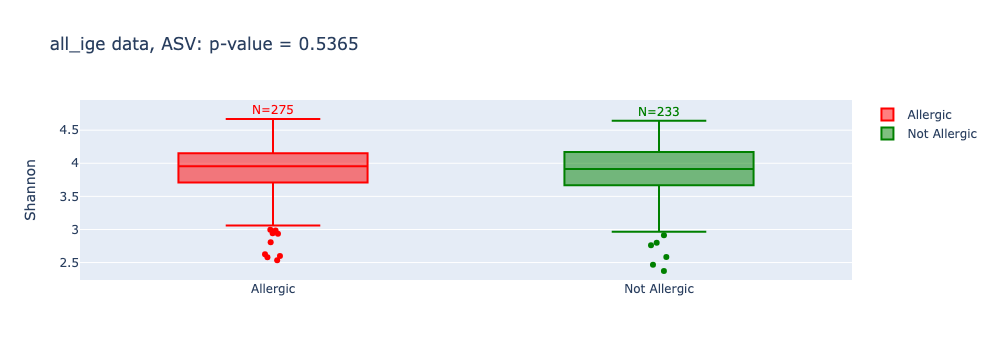

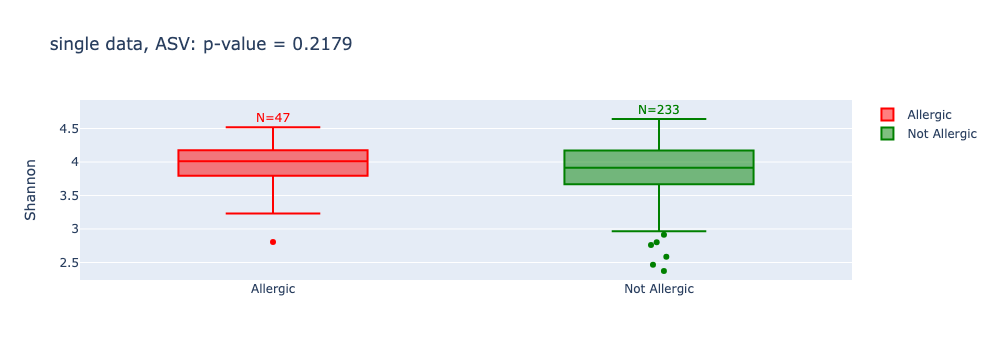

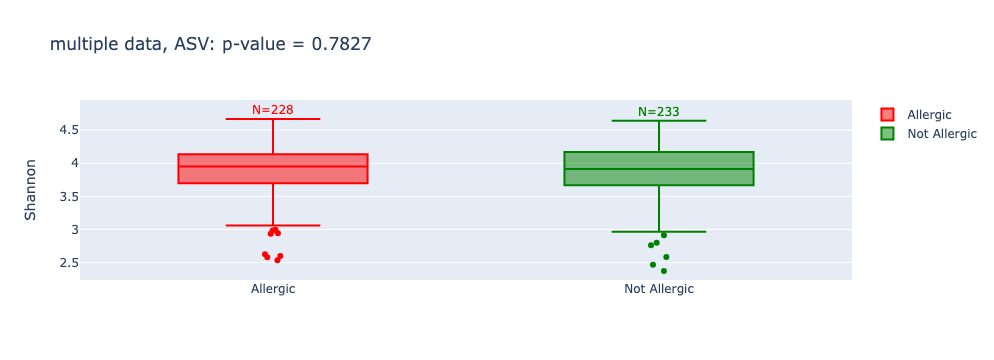

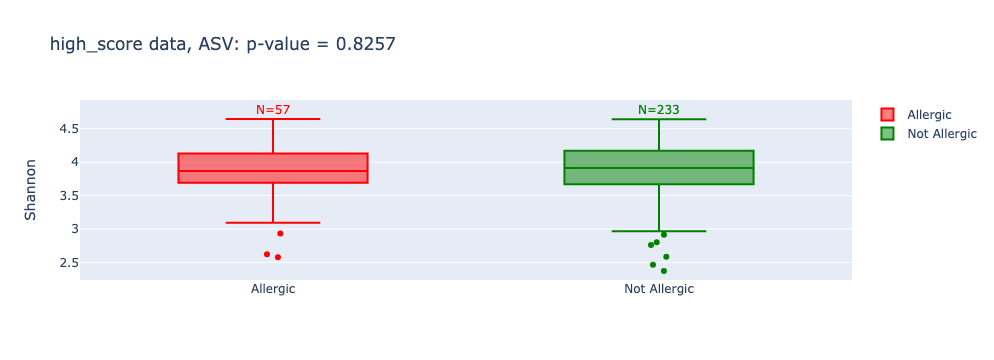

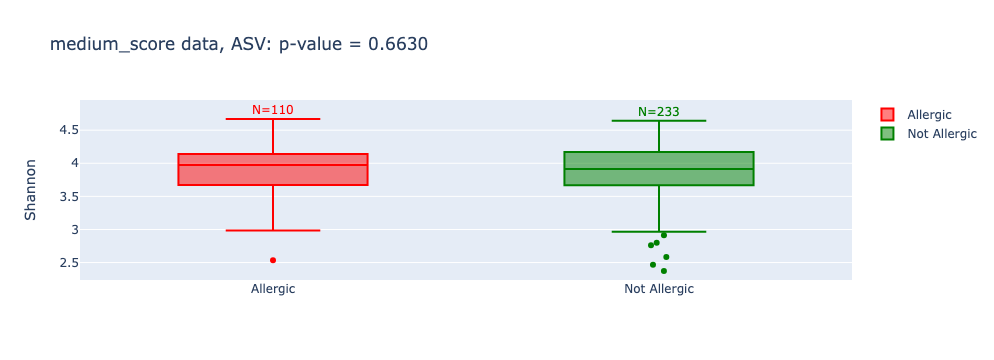

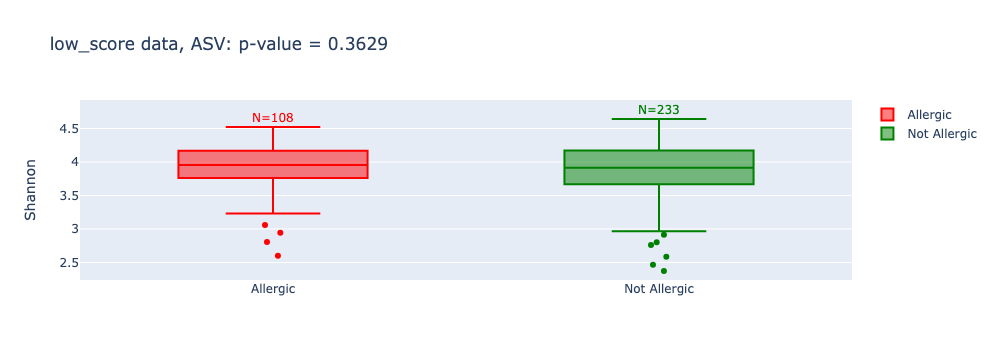

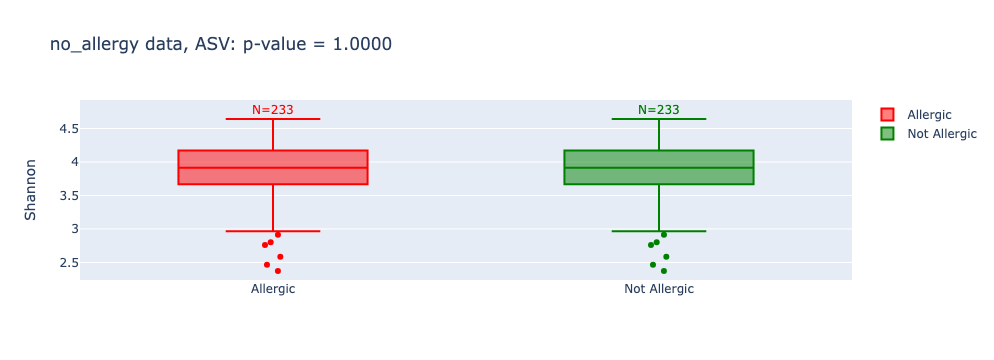

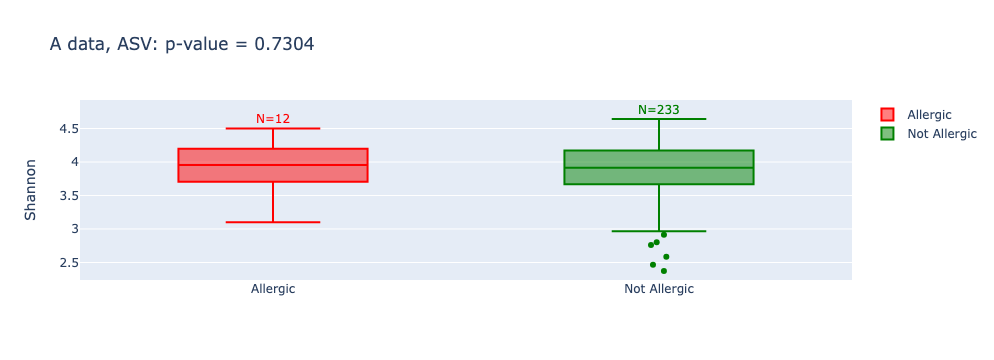

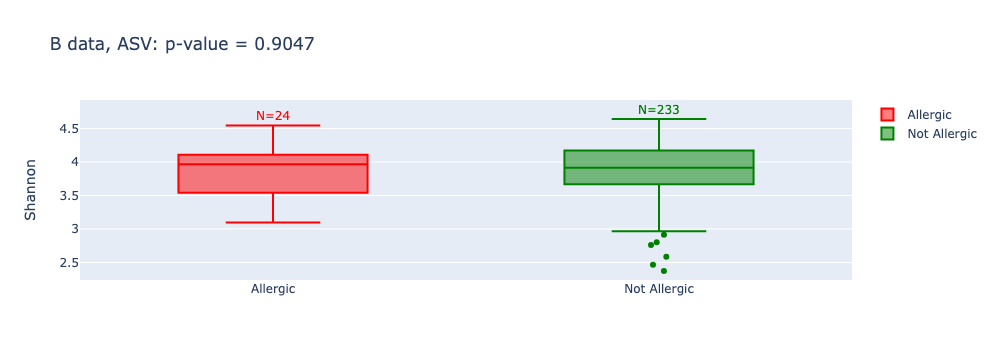

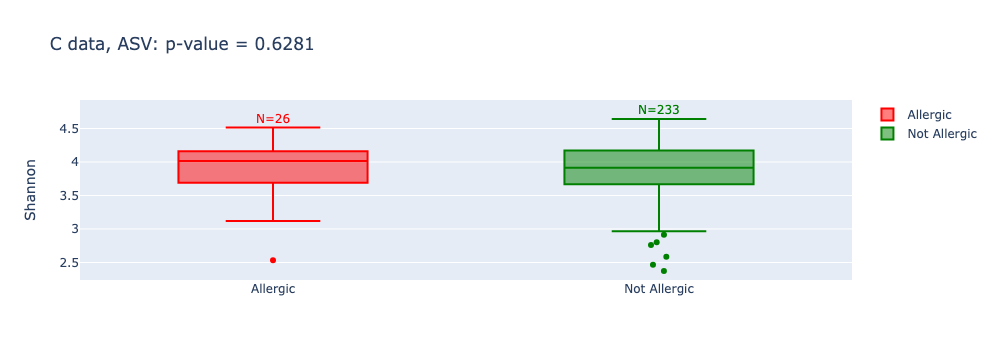

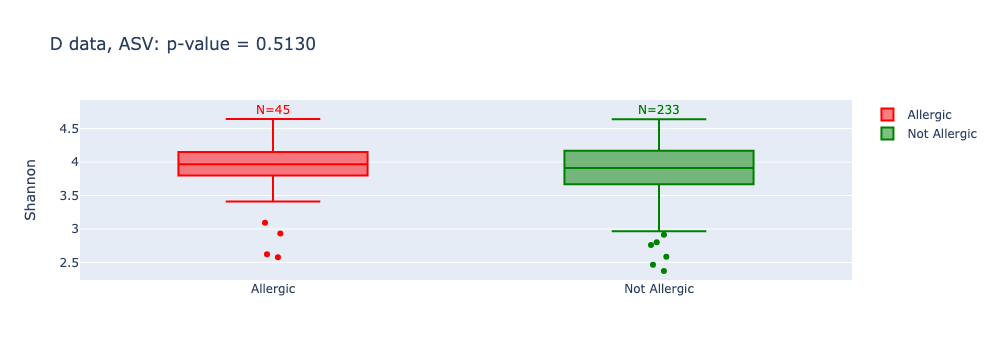

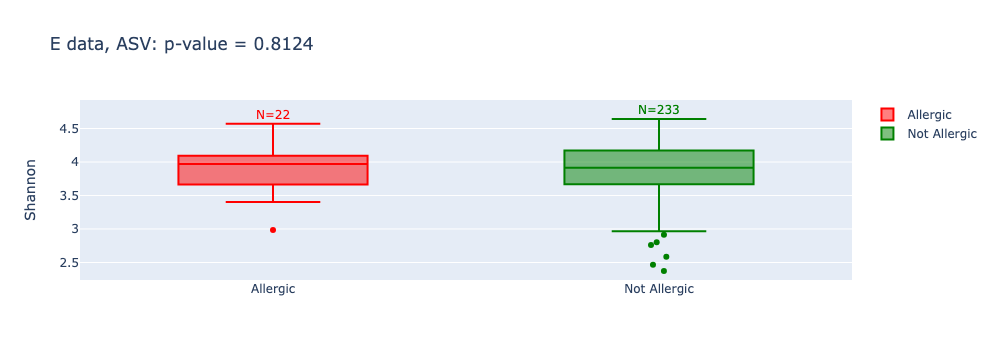

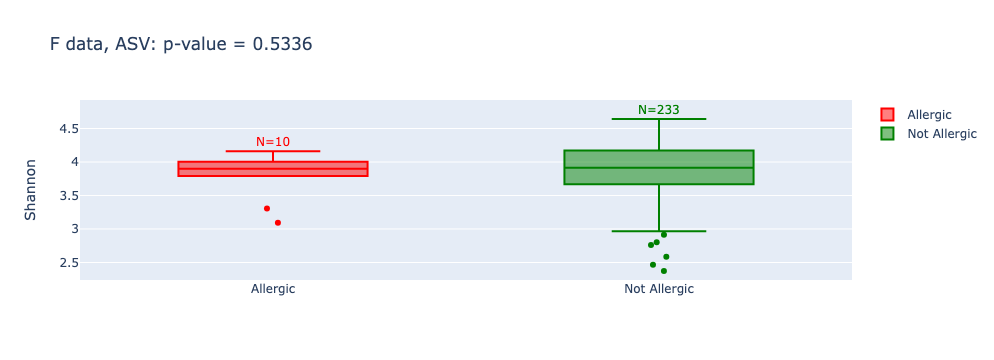

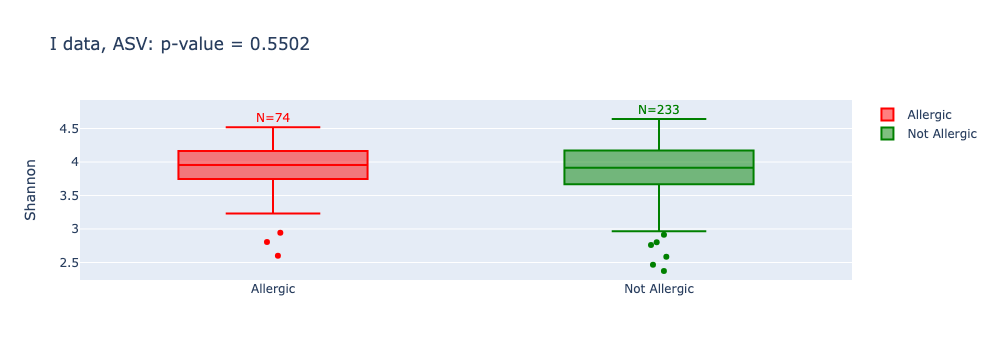

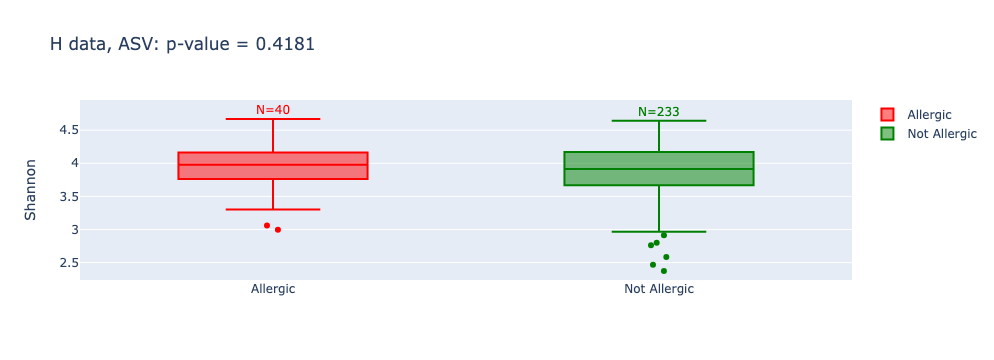

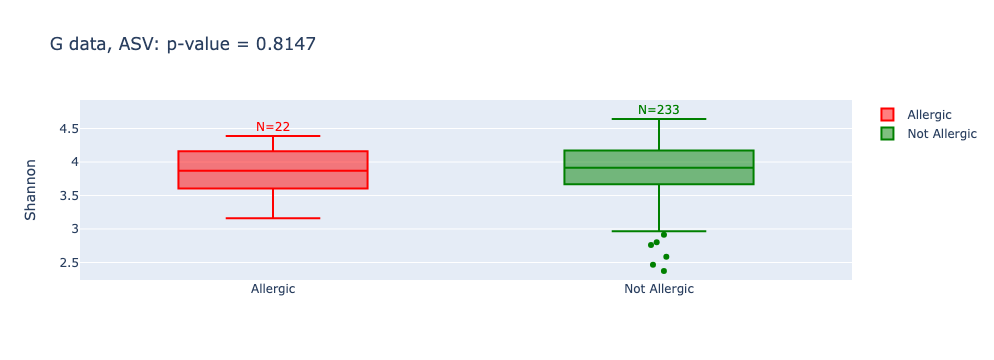

In [17]:
# Plot alpha diversity for ASV level
lvl = "ASV"
for status in allergy_status.keys():
    alpha_diversity_test, alpha_diversity_ctrl = alpha_dict[status][lvl]["alpha_test"], alpha_dict[status][lvl]["alpha_ctrl"]
    res = pvalue_dict["shannon"][status][lvl]
    stat, p_value = res["stat"], res["p-value"]
    fig = plot_alpha_diversity(alpha_diversity_test, alpha_diversity_ctrl, diversity_metric, status, lvl, p_value)
    fig.show()

In [ ]:
img = Image.open('figures/plot1.png')
display.display(img)

### Faith's Phylogenetic Diversity (Faith PD)

In [18]:
tree = TreeNode.read('data/q2/tree/rooted_tree_15170/tree.nwk')
faith_pd_dict = {}

In [19]:
for status in allergy_status.keys():
    print(f"\n ------------ {status} ------------")
    ige_ids = set(map(str, allergy_status[status]))
    non_ids = set(map(str, allergy_status['no_allergy']))
    count_ids = set(count_dict["ASV"]["all"].columns.astype(str))
    overlap_ids = count_ids.intersection(ige_ids | non_ids)
    allergic_ids = set(ige_ids)
    ctrl_ids = set(non_ids)
    allergic_ids_list = list(allergic_ids.intersection(overlap_ids))
    ctrl_ids_list = list(ctrl_ids.intersection(overlap_ids))
    counts = count_dict[level]["all"]
    filtered_counts = counts.loc[:, (counts != 0).any(axis=0)]
    filtered_counts = filtered_counts[(filtered_counts != 0).any(axis=1)]
    taxa_names = filtered_counts.index
    faith_pd_ctrl = {
        col: faith_pd(filtered_counts[col].values, taxa_names, tree)
        for col in ctrl_ids_list if col in filtered_counts.columns
    }
    faith_pd_test = {
        col: faith_pd(filtered_counts[col].values, taxa_names, tree)
        for col in allergic_ids_list if col in filtered_counts.columns
    }
    faith_pd_ctrl_values = list(faith_pd_ctrl.values())
    faith_pd_test_values = list(faith_pd_test.values())
    if status not in pvalue_dict["faith_pd"]:
        pvalue_dict["faith_pd"][status] = {}
    stat, p_value = mannwhitneyu(faith_pd_ctrl_values, faith_pd_test_values, alternative='two-sided')
    print(f"U statistic: {stat}")
    print(f"P-value: {p_value}")
    pvalue_dict["faith_pd"][status][level] = {"stat": stat, "p-value": p_value}
    faith_pd_ctrl_df = pd.DataFrame(list(faith_pd_ctrl.items()), columns=['sample_id', 'faith_pd'])
    faith_pd_ctrl_df['status'] = "no allergy"
    faith_pd_test_df = pd.DataFrame(list(faith_pd_test.items()), columns=['sample_id', 'faith_pd'])
    faith_pd_test_df['status'] = "allergy"
    faith_pd_df = pd.concat([faith_pd_ctrl_df, faith_pd_test_df], ignore_index=True)
    faith_pd_dict[status] = faith_pd_df

In [20]:
# Plot Faith PD
diversity_metric = "faith_pd"
for status in allergy_status.keys():
    faith_pd_df = faith_pd_dict[status].copy()
    fig = px.box(faith_pd_df, x="status", y="faith_pd", color="status", color_discrete_sequence=["green", "red"])
    value_counts = faith_pd_df['status'].value_counts()
    annotations = []
    p_value = pvalue_dict["faith_pd"][status][lvl]["p-value"]
    for index, count in value_counts.items():
        annotations.append(
            go.layout.Annotation(
                x=index,
                y=faith_pd_df[faith_pd_df['status'] == index]['faith_pd'].max() + 1,
                text=f'N = {count}',
                showarrow=False,
                font=dict(size=12),
            )
        )
    fig.update_layout(
        title=f'{status} data, {level}: p-value = {p_value:.4f}',
        width=500,
        height=800,
        annotations=annotations
    )
    fig.show()

### Taxa Grouping and Visualization

In [21]:
control_sample_df = pd.read_csv("data/control_samples.csv", sep=",", index_col=0, low_memory=False)
with open('data/taxa_dict_ige.pickle', 'rb') as file:
    counts_dict = pkl.load(file)

In [23]:
non_ige_sample_ids = list(map(str, control_sample_df.index))
filtered_phylum_df = counts_dict['phylum'].loc[:, ~counts_dict['phylum'].columns.isin(non_ige_sample_ids)]
ige_sample_ids = filtered_phylum_df.columns

In [24]:
for lvl in ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'ASV']:
    print(f"------------  {lvl} ------------")
    raw_counts = counts_dict[lvl]
    print("total counts:", raw_counts.shape[0])
    healthy = raw_counts[non_ige_sample_ids]
    allergic = raw_counts.drop(columns=non_ige_sample_ids, errors='ignore')
    only_healthy = healthy[(healthy != 0).any(axis=1) & (allergic == 0).all(axis=1)]
    only_allergic = allergic[(allergic != 0).any(axis=1) & (healthy == 0).all(axis=1)]
    print("Number of unique taxa in healthy: {0}".format(len(only_healthy)))
    print("Number of unique taxa in allergic: {0}".format(len(only_allergic)))
    print("Number of mixed taxa: {0}".format(raw_counts.shape[0] - len(only_allergic) - len(only_healthy)))
    if lvl == "ASV":
        unique_ASV_color = raw_counts.copy()
        unique_ASV_color['color'] = unique_ASV_color.apply(determine_status, axis=1)

------------  domain ------------
total counts: 2
Number of unique taxa in healthy: 0
Number of unique taxa in allergic: 0
Number of mixed taxa: 2
------------  phylum ------------
total counts: 17
Number of unique taxa in healthy: 2
Number of unique taxa in allergic: 1
Number of mixed taxa: 14
------------  class ------------
total counts: 26
Number of unique taxa in healthy: 3
Number of unique taxa in allergic: 1
Number of mixed taxa: 22
------------  order ------------
total counts: 87
Number of unique taxa in healthy: 14
Number of unique taxa in allergic: 11
Number of mixed taxa: 62
------------  family ------------
total counts: 212
Number of unique taxa in healthy: 49
Number of unique taxa in allergic: 48
Number of mixed taxa: 115
------------  genus ------------
total counts: 1345
Number of unique taxa in healthy: 345
Number of unique taxa in allergic: 364
Number of mixed taxa: 636
------------  species ------------
total counts: 6302
Number of unique taxa in healthy: 1822
Numbe

In [25]:
# Calculate color proportions for each taxonomic level
level_ige_stat = dict()
joined_df = unique_ASV_color.join(taxa)
for lvl in ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']:
    color_df = joined_df.groupby(lvl).apply(calculate_color_proportions).unstack(fill_value=0).reset_index()
    color_df.rename(columns={'green': 'healthy', 'red': 'allergic', 'lightgrey': 'mixed'}, inplace=True)
    color_df.set_index(lvl, inplace=True)
    color_df = color_df.sort_values(by=['allergic', 'healthy'], ascending=[False, False])
    level_ige_stat[lvl] = color_df

In [26]:
# Assign color labels for each group
color_dict = dict()
for lvl in ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']:
    df = level_ige_stat[lvl]
    df.columns.name = None
    conditions = [df['healthy'] == 1, df['allergic'] == 1]
    choices = ['green', 'red']
    df['color'] = np.select(conditions, choices, default='lightgrey')
    color_dict[lvl] = df
    print(lvl, df.color.value_counts())

domain color
lightgrey    2
Name: count, dtype: int64
phylum color
lightgrey    14
green         2
red           1
Name: count, dtype: int64
class color
lightgrey    22
green         3
red           1
Name: count, dtype: int64
order color
lightgrey    62
green        14
red          11
Name: count, dtype: int64
family color
lightgrey    115
green         49
red           48
Name: count, dtype: int64
genus color
lightgrey    636
red          364
green        345
Name: count, dtype: int64
species color
lightgrey    2442
red          2038
green        1822
Name: count, dtype: int64


In [27]:
# Create manifest file for unique taxa
taxonomy_unique = unique_ASV_color['color'].to_frame().join(taxa['name'])
taxonomy_unique.columns = ['status', 'Taxon']
taxonomy_unique = taxonomy_unique[['Taxon', 'status']]
taxonomy_unique.to_csv('data/taxonomy_unique.tsv', sep="\t", index=True)

In [28]:
# Stacked barplots for each taxonomic level
for lvl in ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']:
    df = level_ige_stat[lvl]
    fig = create_stacked_bar_plot(df, lvl=lvl, width=4500)

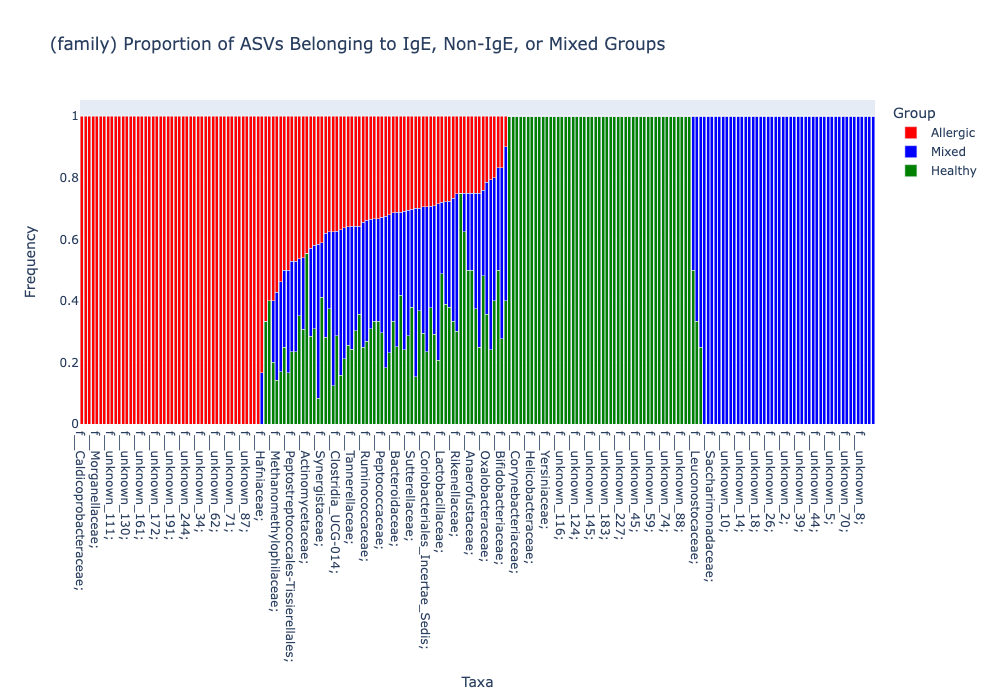

In [29]:
for lvl in ['family']:
    df = level_ige_stat[lvl]
    fig = create_stacked_bar_plot(df, lvl=lvl, width=3500)
    fig.show()

In [ ]:
img = Image.open('figures/plot2.png')
display.display(img)

### Family Heatmap and Abundance Barplots

In [30]:
family_names_dict = {
    "main": [
        'f__Izemoplasmatales;',
        'f__Akkermansiaceae;',
        'f__Methanomethylophilaceae;',
        'f__Barnesiellaceae;',
        'f__Clostridiaceae;',
        'f__Pasteurellaceae;',
        'f__Monoglobaceae;',
        'f__Clostridia_vadinBB60_group;',
        'f__Porphyromonadaceae;',
        'f__UCG-010;',
        'f__[Eubacterium]_coprostanoligenes_group;',
        'f__Christensenellaceae;',
        'f__Coriobacteriales_Incertae_Sedis;',
        'f__vadinBE97;',
        'f__Peptostreptococcales-Tissierellales;',
        'f__Oscillospiraceae;',
        'f__Atopobiaceae;',
        'f__Tannerellaceae;',
        'f__Coriobacteriaceae;',
        'f__Anaerovoracaceae;',
        'f__Staphylococcaceae;',
        'f__Bacteroidaceae;',
        'f__Butyricicoccaceae;',
        'f__Ruminococcaceae;',
        'f__Bifidobacteriaceae;',
        'f__Eggerthellaceae;',
        'f__Hungateiclostridiaceae;',
        'f__Lachnospiraceae;',
        'f__Clostridia_UCG-014;',
        'f__Defluviitaleaceae;',
        'f__Streptococcaceae;',
        'f__Peptococcaceae;',
        'f__Rikenellaceae;',
        'f__RF39;',
        'f__Veillonellaceae;',
        'f__Marinifilaceae;',
        'f__Erysipelatoclostridiaceae;',
        'f__Succinivibrionaceae;',
        'f__Gastranaerophilales;',
        'f__Erysipelotrichaceae;',
        'f__Chloroplast;',
        'f__Muribaculaceae;',
        'f__Oxalobacteraceae;',
        'f__Peptostreptococcaceae;',
        'f__Desulfovibrionaceae;',
        'f__Methanobacteriaceae;',
        'f__Enterococcaceae;',
        'f__Prevotellaceae;',
        'f__Enterobacteriaceae;',
        'f__Sutterellaceae;',
        'f__Puniceicoccaceae;',
        'f__Victivallaceae;',
        'f__Flavobacteriaceae;',
        'f__Synergistaceae;',
        'f__Acidaminococcaceae;',
        'f__Selenomonadaceae;',
        'f__Lactobacillaceae;',
        'f__Fusobacteriaceae;',
        'f__Anaerofustaceae;',
        'f__Acholeplasmataceae;',
        'f__[Clostridium]_methylpentosum_group;',
    ],
    "mixed": [
        'f__Saccharimonadaceae;',
        'f__Oscillospirales;',
        'f__Carnobacteriaceae;',
    ],
    "hafni": [
        'f__Hafniaceae;',
    ],
    "healthy": [
        'f__Shewanellaceae;',
        'f__Morganellaceae;',
        'f__Micrococcaceae;',
        'f__Methanocorpusculaceae;',
        'f__Comamonadaceae;',
        'f__Caldicoprobacteraceae;'
    ],
    "healthy_allergy": [
        'f__Actinomycetaceae;',
        'f__Elusimicrobiaceae;',
        'f__Eubacteriaceae;',
        'f__Campylobacteraceae;'
    ],
    "allergy_mixed": [
        'f__Ethanoligenenaceae;',
        'f__Leuconostocaceae;',
        'f__DTU014;'
    ],
    "allergy": [
        'f__Yersiniaceae;',
        'f__WPS-2;',
        'f__Propionibacteriaceae;',
        'f__Leptotrichiaceae;',
        'f__Helicobacteraceae;',
        'f__Halomonadaceae;',
        'f__Gemellaceae;',
        'f__Dysgonomonadaceae;',
        'f__Corynebacteriaceae;',
        'f__Brevibacteriaceae;',
        'f__Brachyspiraceae;'
    ]
}

In [ ]:
ige_clustered = pd.read_csv("data/ige_clustered.csv", sep=",", index_col=0, low_memory=False)
control_samples = pd.read_csv("data/control_samples.csv", sep=",", index_col=0, low_memory=False)
vis_ige = pd.concat([ige_clustered, control_samples])[ige_clustered.columns]

with open('data/taxa_dict_ige.pickle', 'rb') as file:
    counts_dict = pkl.load(file)

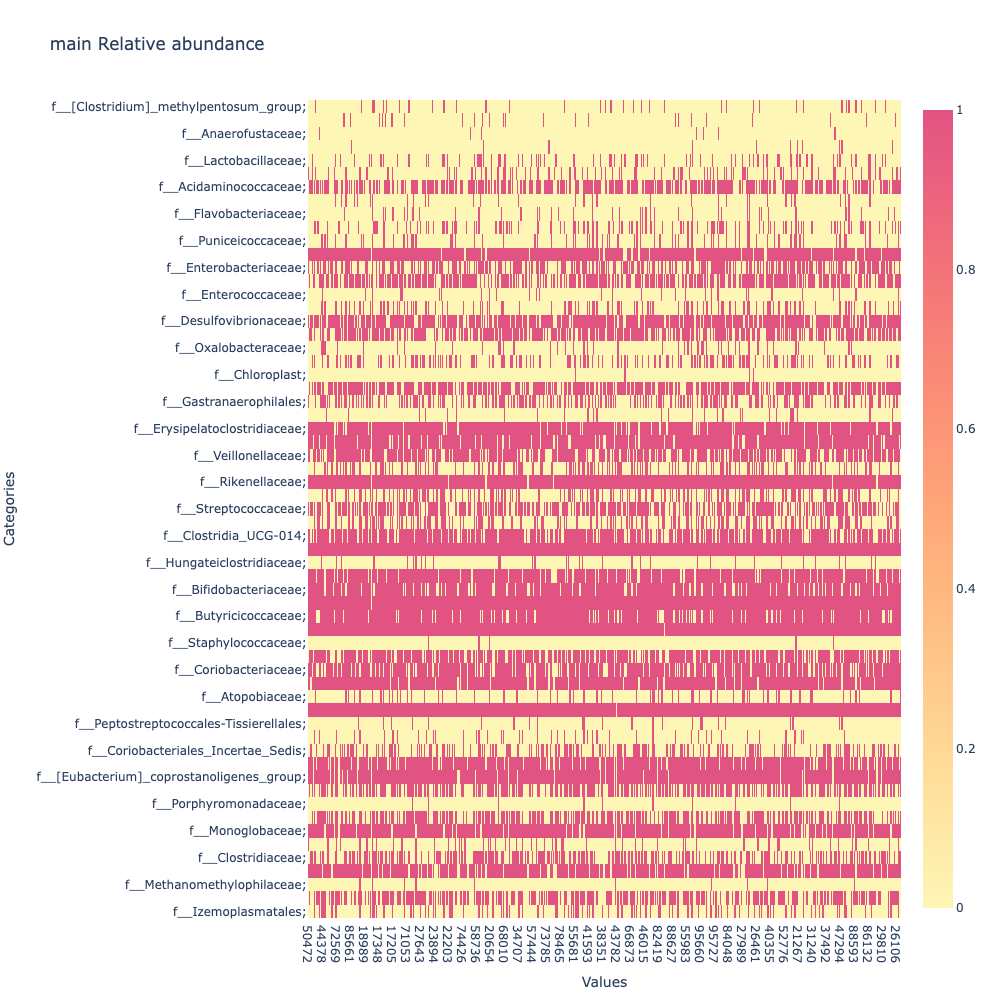

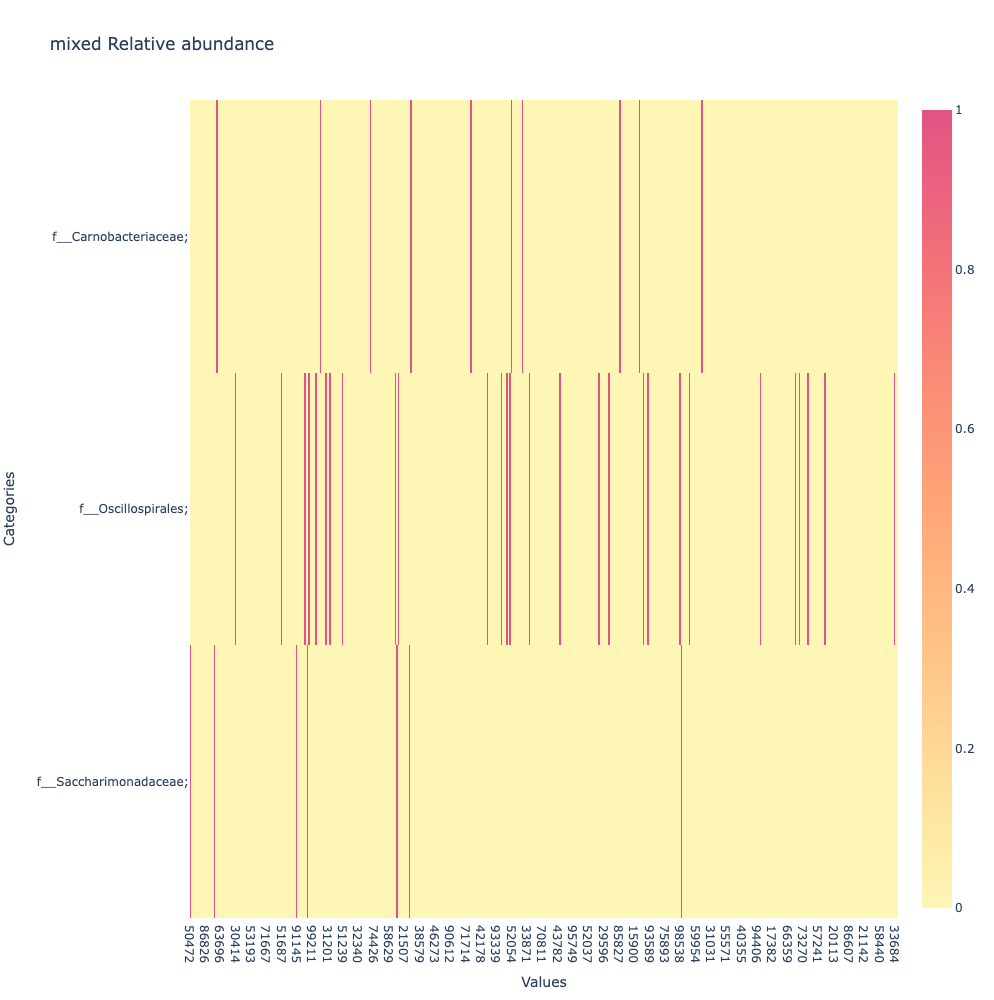

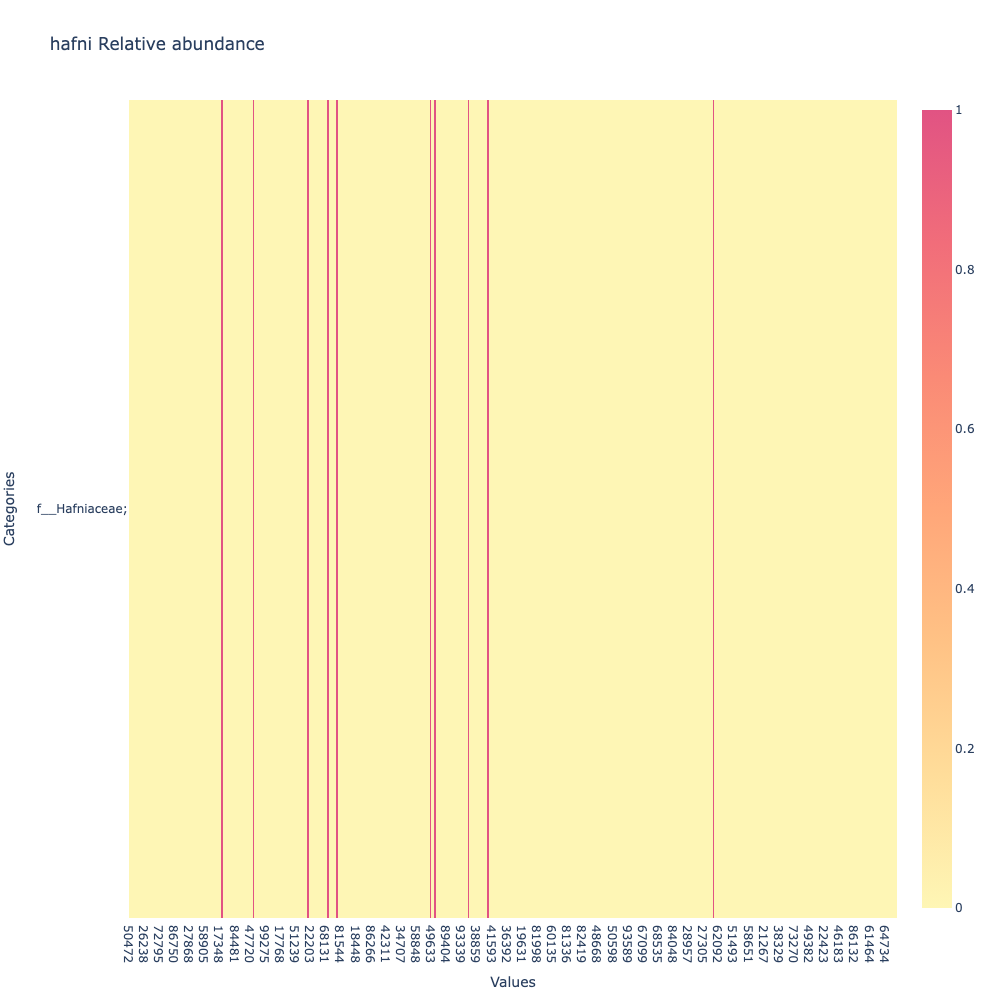

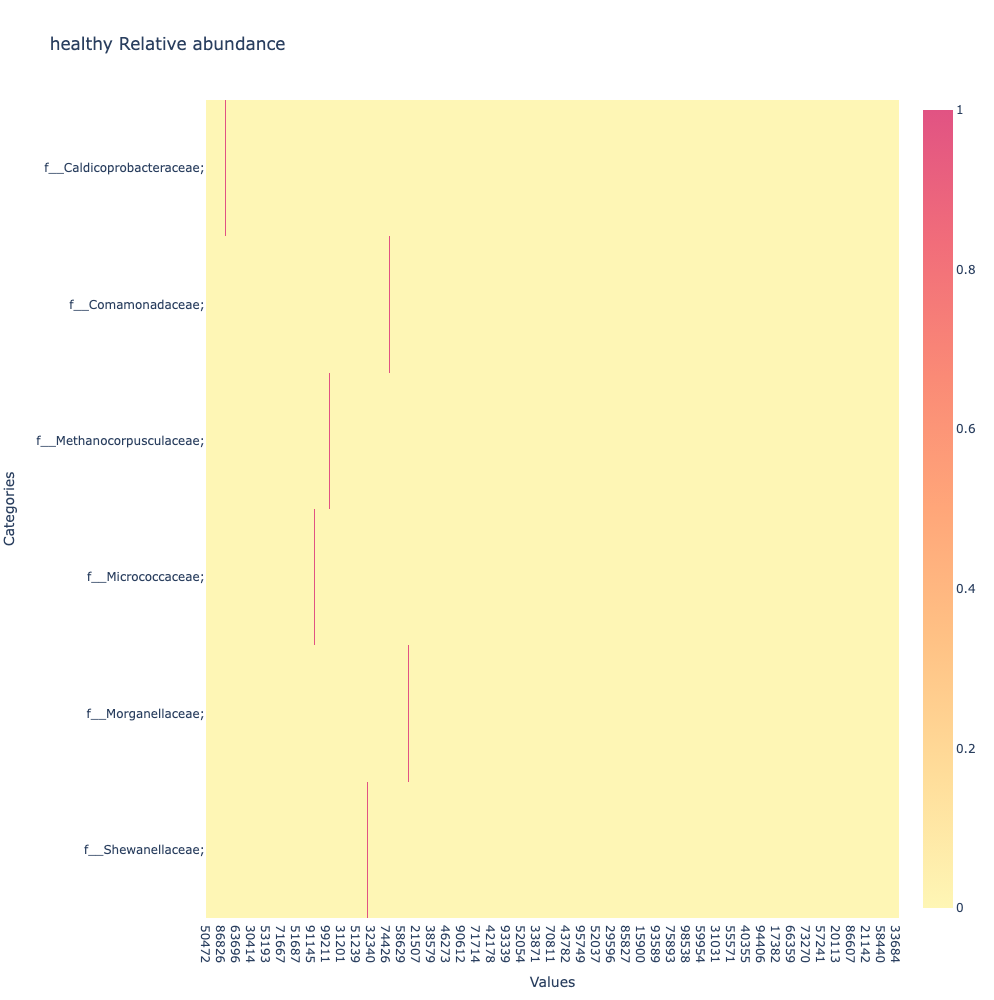

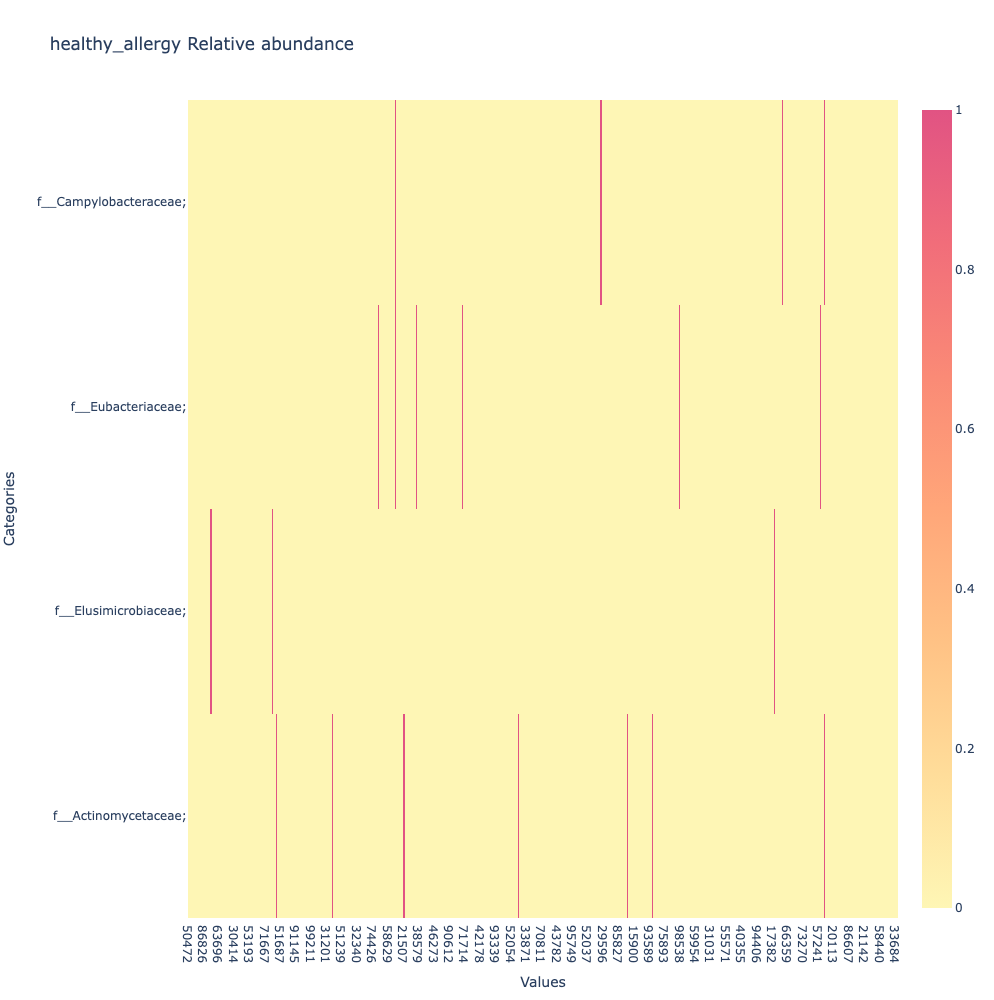

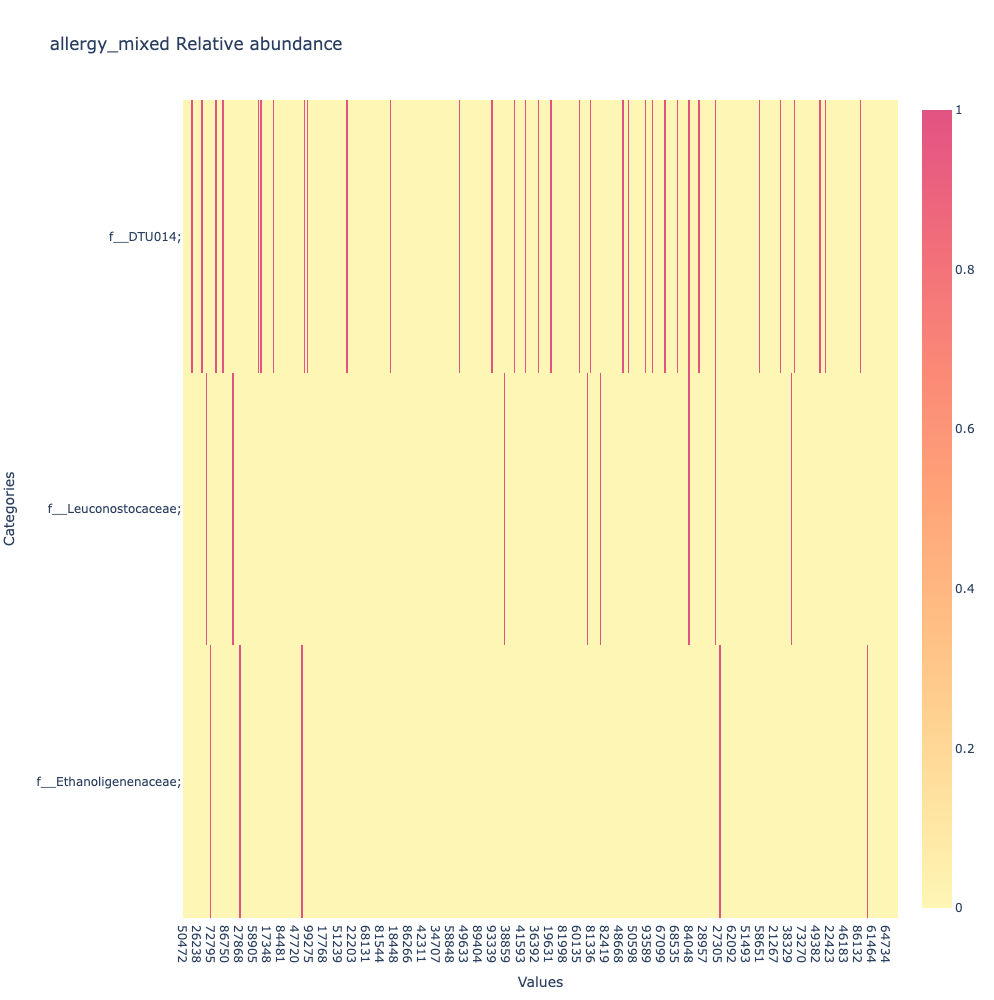

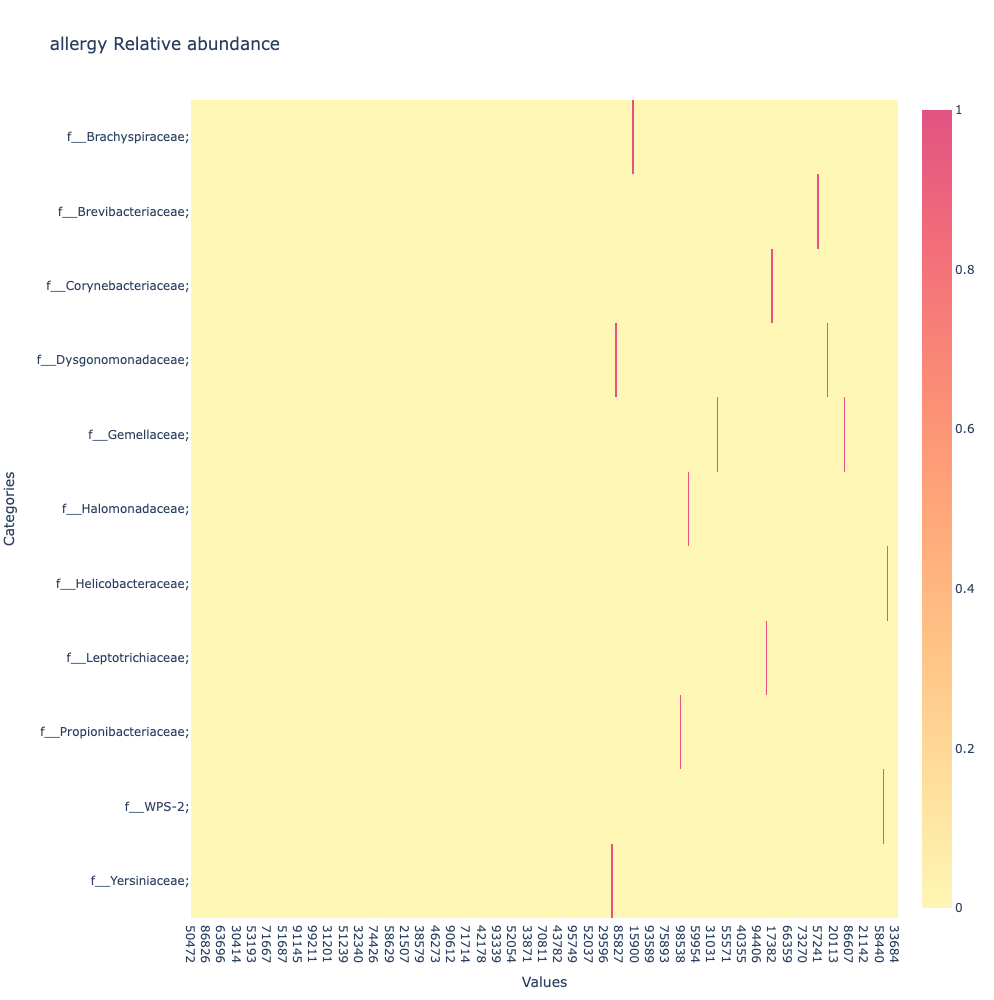

In [32]:
lvl = 'family'
for key in family_names_dict.keys():
    raw_counts = counts_dict[lvl]
    col_sums = raw_counts.sum(axis=0)
    rel_abundance = raw_counts.div(col_sums, axis=1)
    rel_abundance.index = rel_abundance.index.str.extract(r'(f__[^;]+;)')[0]
    rel_abundance = rel_abundance.loc[rel_abundance.index.intersection(family_names_dict[key])]
    reordered_counts = rel_abundance.reindex(family_names_dict[key])
    clustered_counts = reordered_counts[list(map(str, vis_ige.index))]
    clustered_counts_bool = clustered_counts.astype(bool).astype(int)
    heatmap = go.Figure(data=go.Heatmap(
        z=clustered_counts_bool,
        x=clustered_counts_bool.columns,
        y=clustered_counts_bool.index,
        colorscale='pinkyl',
        zmin=0, zmax=1,
    ))
    heatmap.update_layout(
        xaxis_title='Values',
        yaxis_title='Categories',
        title=f'{key} Relative abundance',
        width=1000, height=1000
    )
    heatmap.show()

In [ ]:
img = Image.open('figures/plot3.png')
display.display(img)

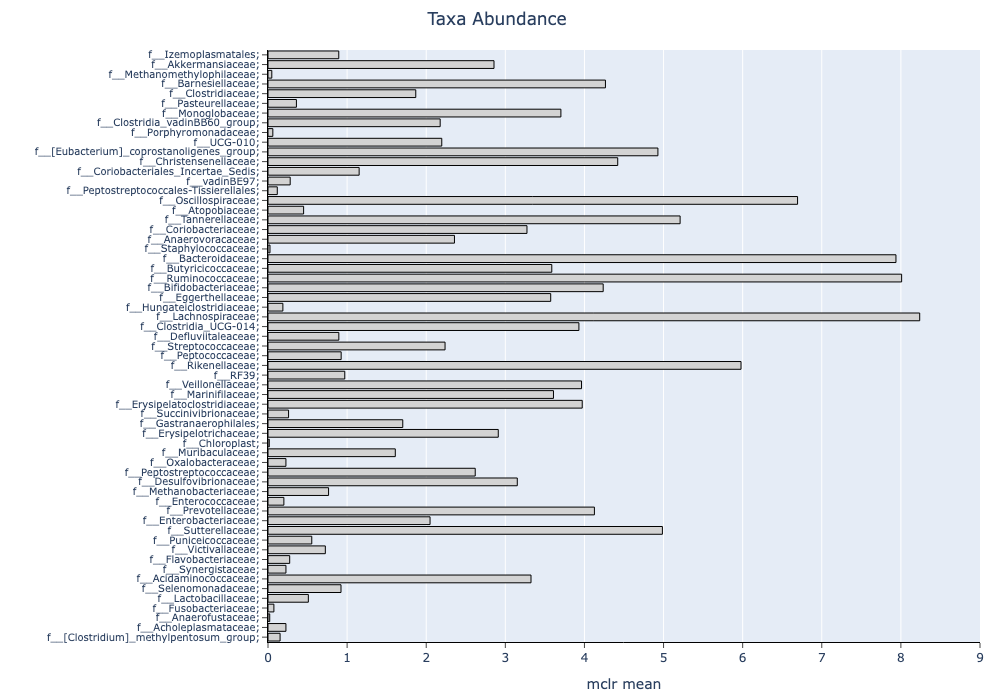

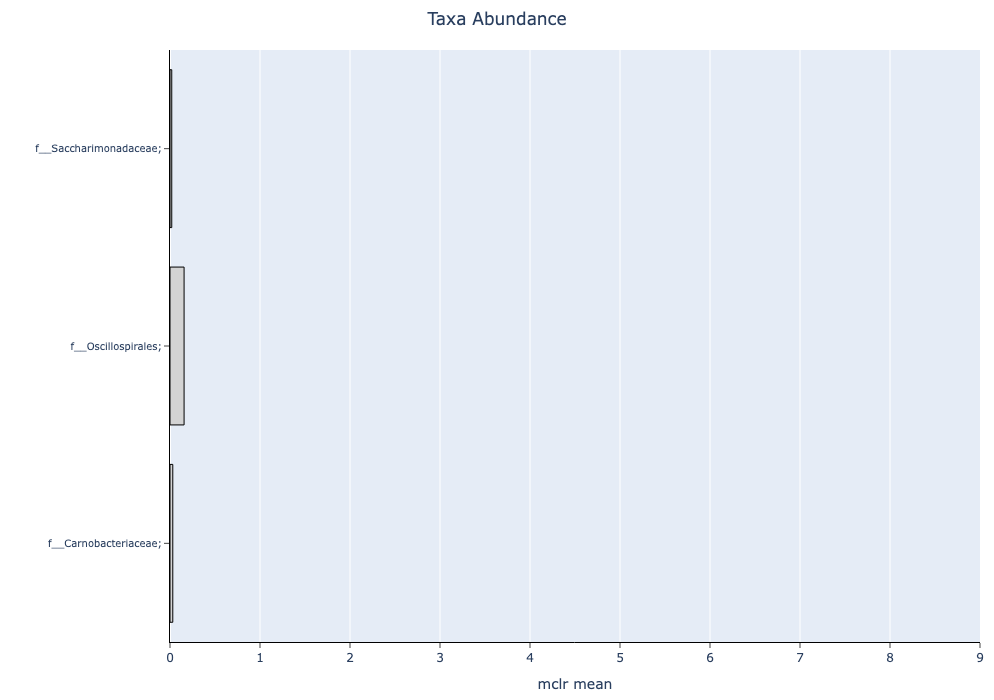

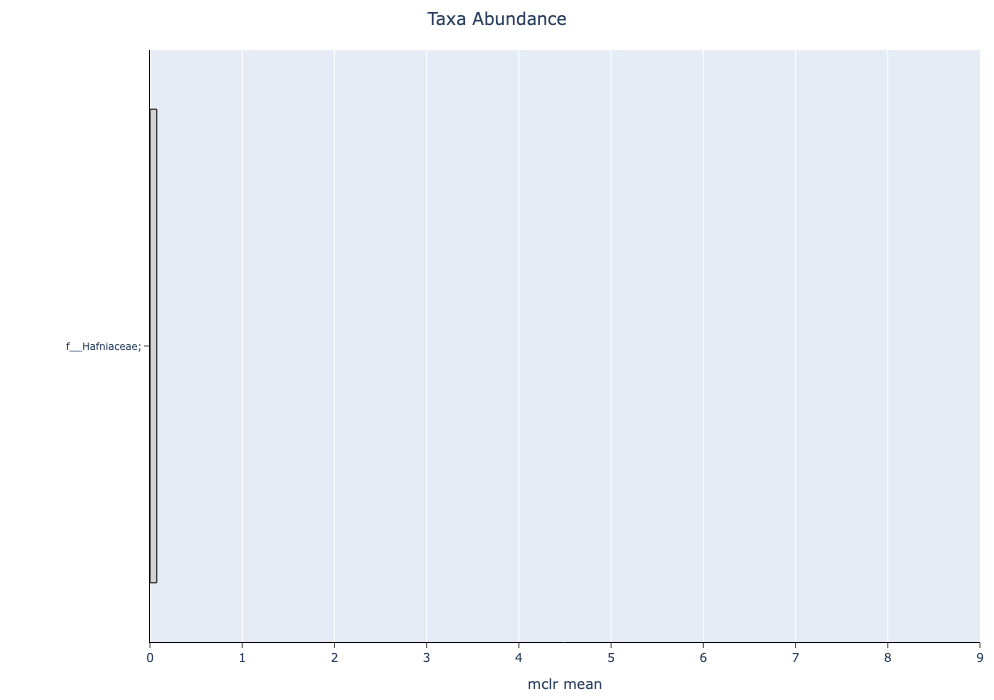

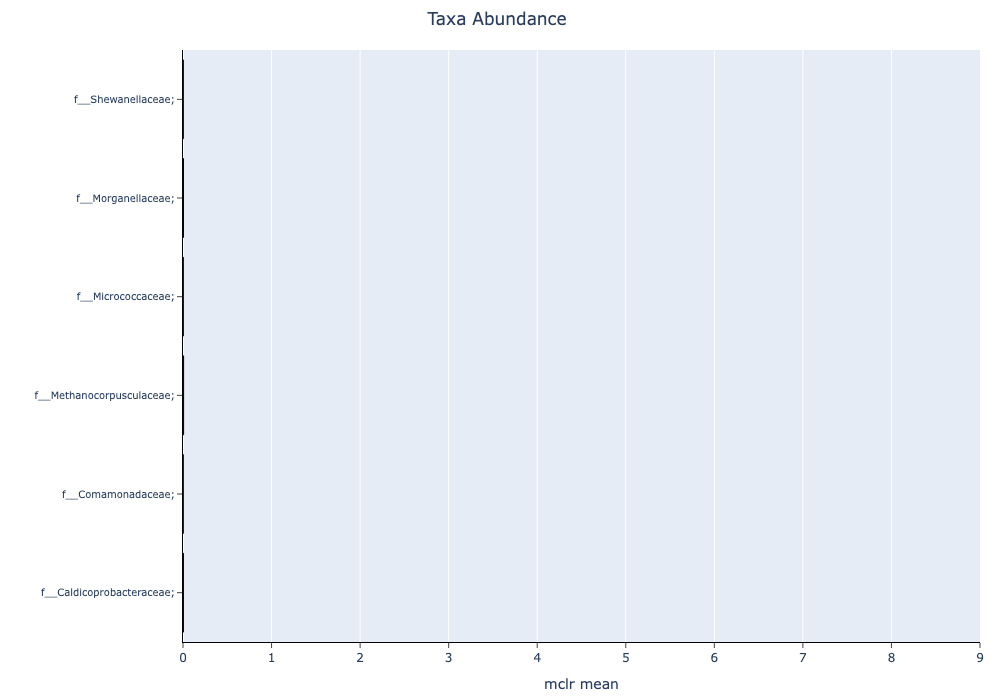

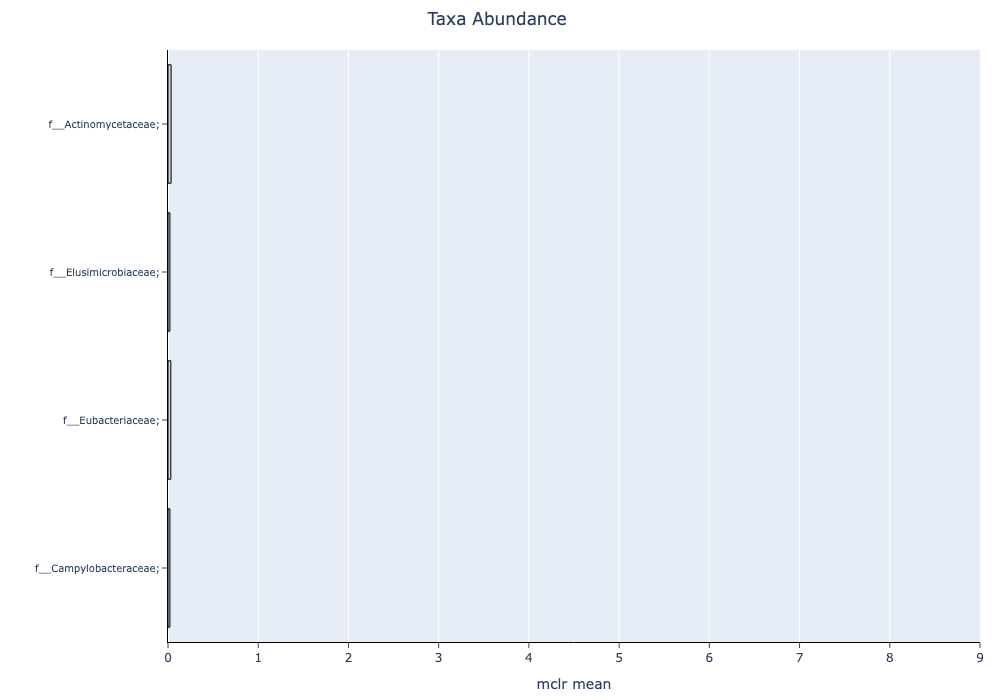

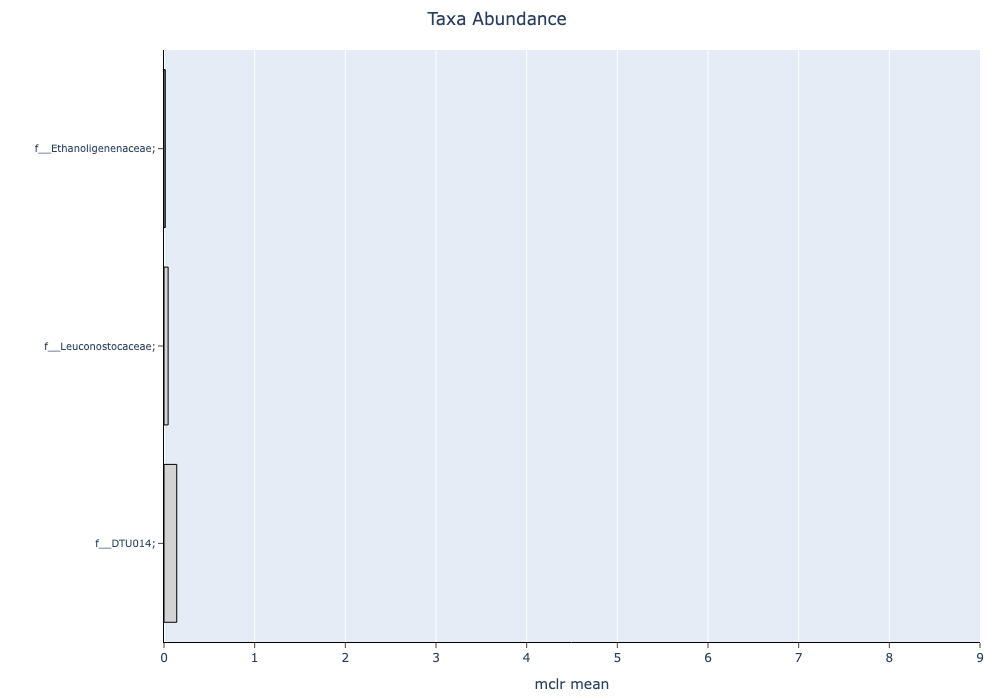

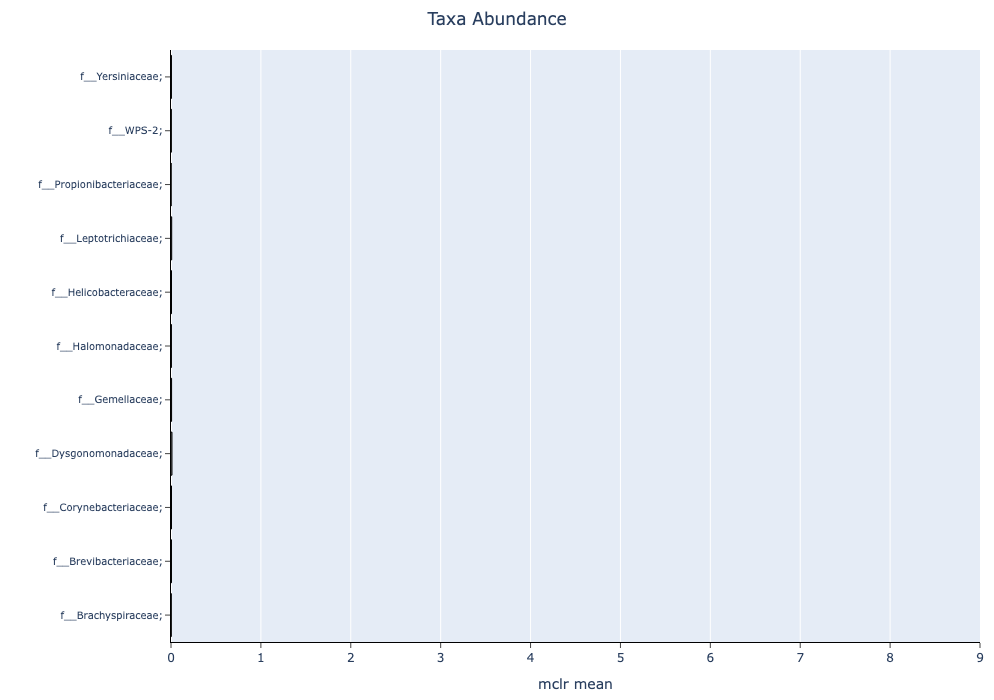

In [34]:
# mclr mean abundance barplots
all_family_names = [family for families in family_names_dict.values() for family in families]
raw_counts = counts_dict[lvl]
raw_counts.index = raw_counts.index.str.extract(r'(f__[^;]+;)')[0]
raw_counts = raw_counts.loc[raw_counts.index.intersection(set(all_family_names))]
reordered_counts = raw_counts.reindex(all_family_names)
clustered_counts = reordered_counts[list(map(str, vis_ige.index))]
mclr_counts = transform_features(clustered_counts, transformation='mclr')
mean_mclr = mclr_counts.mean(axis=1)
vis_df = pd.DataFrame({'Taxa': mean_mclr.index, 'mclr_mean': mean_mclr.values})
vis_df.index = vis_df["Taxa"]
for key in family_names_dict.keys():
    vis_df_small = vis_df.loc[vis_df.index.intersection(family_names_dict[key])].iloc[::-1]
    fig = px.bar(
        vis_df_small,
        x='mclr_mean',
        y='Taxa',
        orientation='h',
        title='Taxa Abundance',
        labels={'mclr_mean': 'mclr mean', 'Taxa': ''}
    )
    fig.update_traces(marker_color='lightgray', marker_line_color='black', marker_line_width=1)
    fig.update_layout(
        xaxis=dict(title="mclr mean", showline=True, linecolor="black", linewidth=1, ticks="outside", range=[0, 9]),
        yaxis=dict(title="", showline=True, linecolor="black", linewidth=1, tickmode="linear", ticks="outside", tickfont=dict(size=10)),
        title={'x': 0.5},
        height=700,
        margin=dict(l=150, r=10, t=50, b=50)
    )
    fig.show()

In [ ]:
img = Image.open('figures/plot4.png')
display.display(img)

### Sankey Diagram for Taxonomic Flow

In [38]:
non_mixed_ige_dict = dict()

for lvl in color_dict.keys():
    df = color_dict[lvl][(color_dict[lvl]['mixed'] == 0)] ### this excludes mixed
    df = color_dict[lvl]
    print(lvl, df.shape[0])
    non_mixed_ige_dict[lvl] = df

domain 2
phylum 17
class 26
order 87
family 212
genus 1345
species 6302


In [40]:
filtered_counts = dict()

# Loop through each taxonomic level and process accordingly
for i, lvl in enumerate(['domain', 'phylum', 'class', 'order']):
    # Get the corresponding DataFrame for the level from color_dict
    df = counts_dict[lvl].copy()
    
    ### remove blank spaces in the indices
    df.index = df.index.str.replace(" ", "")

    # Extract the correct rank part from the 'name' column
    df[lvl] = extract_rank(df, i)  # Use the 'extract_rank' function, assuming it extracts the rank based on index
    
    # Filter rows where the level from the first DataFrame exists in the index of the non_mixed_ige_dict for the same level
    df = df[df[lvl].isin(non_mixed_ige_dict[lvl].index)]
    
    filtered_counts[lvl] = df
    
    # Drop the column containing the taxonomic level name if not needed
    df = df.drop(columns=lvl)
    
    print(lvl, df.shape)

domain (2, 508)
phylum (17, 508)
class (26, 508)
order (87, 508)


In [41]:
links = []
labels = []
label_index = {}
family_list = list()
domain_df = join_dataframes(filtered_counts, color_dict, "domain")
phylum_df = join_dataframes(filtered_counts, color_dict, "phylum")
class_df = join_dataframes(filtered_counts, color_dict, "class")
order_df = join_dataframes(filtered_counts, color_dict, "order")
sample_ids = counts_dict["domain"].columns

In [43]:
# Build Sankey links
for domain_name in domain_df.index:
    add_label(domain_name)
    domain_counts = domain_df[sample_ids].astype(bool).astype(int).sum(axis=1)
    domain_color = domain_df.loc[domain_name, 'color']
    for phylum_name in phylum_df.index:
        if domain_name in phylum_name:
            add_label(phylum_name)
            phylum_counts = phylum_df[sample_ids].astype(bool).astype(int).sum(axis=1)
            phylum_color = phylum_df.loc[phylum_name, 'color']
            links.append((label_index[domain_name], label_index[phylum_name], phylum_counts[phylum_name], phylum_color))
            for class_name in class_df.index:
                if phylum_name in class_name:
                    add_label(class_name)
                    class_counts = class_df[sample_ids].astype(bool).astype(int).sum(axis=1)
                    class_color = class_df.loc[class_name, 'color']
                    links.append((label_index[phylum_name], label_index[class_name], class_counts[class_name], class_color))
                    for order_name in order_df.index:
                        if class_name in order_name:
                            add_label(order_name)
                            order_counts = order_df[sample_ids].astype(bool).astype(int).sum(axis=1)
                            order_color = order_df.loc[order_name, 'color']
                            links.append((label_index[class_name], label_index[order_name], order_counts[order_name], order_color))

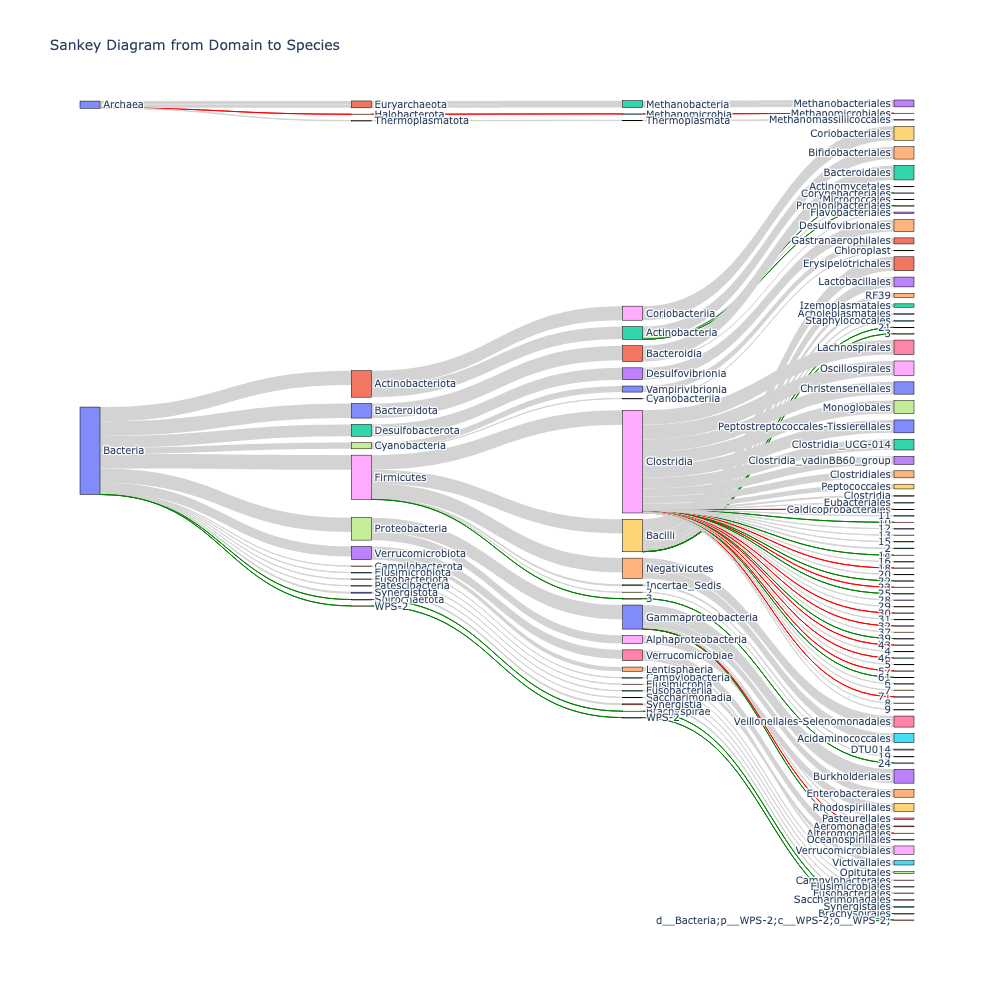

In [44]:
source, target, value, colors = zip(*links)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    ))])
fig.update_layout(title_text="Sankey Diagram from Domain to Species", font_size=10, height=1000, width=1000)
fig.show()

In [ ]:
img = Image.open('figures/plot5.png')
display.display(img)

In [ ]:
# Stacked barplot for families in Sankey order
extracted_families = [item.split('f__')[-1] for item in family_list]
formatted_families = [f'f__{family}' for family in extracted_families]
family_df = level_ige_stat['family']
family_df.index = family_df.index.str.strip()
family_df = family_df.reindex(formatted_families)
fig = create_stacked_bar_plot(family_df, lvl='family', width=4500)